In [1]:
import pandas as pd
import numpy as np

In [2]:
print('Hello Capstone Project Course!')

Hello Capstone Project Course!


In [317]:
import random # library for random number generation
import numpy as np # library for vectorized computation
import pandas as pd # library to process data as dataframes

import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 

from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

from ethnicolr import census_ln, pred_census_ln

import warnings
warnings.filterwarnings('ignore')

print('Libraries imported.')

Libraries imported.


In [4]:
# Where should I bring my friend?

In [5]:
# Init login information 

In [18]:
CLIENT_ID = '5PFGDSXXUVZQ4I32OPZOYZDR0AU3YX5X2DY14TGHFRW0YHHW' # your Foursquare ID
CLIENT_SECRET = 'RYKT0PNIQZGKUB5CWQXNPXAILAUOPS3KKSNVQIV5HBKCORGY' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5PFGDSXXUVZQ4I32OPZOYZDR0AU3YX5X2DY14TGHFRW0YHHW
CLIENT_SECRET:RYKT0PNIQZGKUB5CWQXNPXAILAUOPS3KKSNVQIV5HBKCORGY


In [19]:
# Step one, find target location of interest

In [20]:
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True)

In [21]:
# Get coordinates for all regions in San Diego county  
def get_cor(postal_code):
    zipcode = search.by_zipcode(str(postal_code))
    return [postal_code,zipcode.major_city,zipcode.lat,zipcode.lng]

# San Diego county zipcodes range from 91901 to 92199
df_SD_locations = pd.DataFrame([get_cor(postal_code) for postal_code in range(91901,92199)],columns=['Zipcode','Region','Lat','Lng']).set_index('Zipcode').dropna(axis = 0) 

In [69]:
# create map of Toronto using latitude and longitude values
map_SD = folium.Map(location=[df_SD_locations.Lat.mean(), df_SD_locations.Lng.mean()], zoom_start=10,tiles = 'OpenStreetMap')

# add markers to map
for lat, lng, region in zip(df_SD_locations['Lat'], df_SD_locations['Lng'], df_SD_locations['Region']):
    label = '{}'.format(region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=True).add_to(map_SD)  
    
map_SD

In [57]:
map_SD.save('SD.html')


In [83]:
# Use the function from week3 to get nearby venues for each Postcode
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postcode', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:

Venues = getNearbyVenues(df_SD_locations.index, df_SD_locations.Lat, df_SD_locations.Lng, radius=1000)


In [155]:
Venues = SD_venues

In [8]:
Venues = pd.read_pickle('SD_venues.pkl')

In [9]:
Food_category = ['Coffee Shop', 'Ice Cream Shop','Donut Shop','Dessert Shop','Frozen Yogurt Shop', 'Bubble Tea Shop',' Cupcake Shop'
'Pizza Place', 'Sandwich Place', 'Taco Place', 'Salad Place','Poke Place', 'Snack Place', 'Burrito Place']
Restaurant_category = Venues[Venues['Venue Category'].str.contains('Restaurant')]['Venue Category']
Shopping_category = Venues[Venues['Venue Category'].str.contains('Shop')]['Venue Category']

Pharmacy_category = Venues[Venues['Venue Category'].str.contains('Pharmacy')]['Venue Category']
Shopping_mall_category = ['Shopping Mall']

In [10]:
# Where to eat and where to shop

In [11]:
# Count the number of categories in each loaciton

In [12]:
Food_count = Venues[Venues['Venue Category'].apply(lambda x:x in Food_category)].groupby('Neighborhood')['Venue Category'].nunique()
Restaurant_count = Venues[Venues['Venue Category'].apply(lambda x:x in list(Restaurant_category))].groupby('Neighborhood')['Venue Category'].nunique()
Shopping_count = Venues[Venues['Venue Category'].apply(lambda x:x in list(Shopping_category))].groupby('Neighborhood')['Venue Category'].nunique()
Pharmacy_list = Venues[Venues['Venue Category'].apply(lambda x:x in list(Pharmacy_category))]
Shopping_list = Venues[Venues['Venue Category'].apply(lambda x:x in list(Shopping_mall_category))]
df_count = pd.DataFrame([Food_count,Restaurant_count,Shopping_count]).fillna(0).T.astype(int)
df_count.columns = ['Food','Restaurant','Shopping']

In [13]:
df_count['Total'] = df_count.sum(axis = 1)

In [14]:
for col in ['Food','Restaurant','Shopping']:
    df_count[col] = df_count[col]

In [15]:
df_count['Total'] = df_count['Total'].apply(lambda x:x/max(df_count['Total']))

In [353]:
df_map =  df_SD_locations.merge(df_count,left_index = True,right_index=True)

In [281]:
# create map of Toronto using latitude and longitude values
map_SD = folium.Map(location=[df_map.Lat.mean(), df_map.Lng.mean()], zoom_start=10,tiles = 'OpenStreetMap',width=500,height=500)

# add markers to map
for lat, lng, region,size in zip(df_map['Lat'], df_map['Lng'], df_map['Region'],df_map['Food']):
    label = '{}'.format(region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=size,
        popup=label,
        color='',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=True).add_to(map_SD)  

map_SD

In [282]:
# create map of Toronto using latitude and longitude values
map_SD = folium.Map(location=[df_map.Lat.mean(), df_map.Lng.mean()], zoom_start=10,tiles = 'OpenStreetMap',width=500,height=500)

# add markers to map
for lat, lng, region,size in zip(df_map['Lat'], df_map['Lng'], df_map['Region'],df_map['Restaurant']):
    label = '{}'.format(region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=size,
        popup=label,
        color='',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=True).add_to(map_SD)  

map_SD

In [318]:
# create map using latitude and longitude values
map_SD = folium.Map(location=[df_map.Lat.mean(), df_map.Lng.mean()], zoom_start=10,tiles = 'OpenStreetMap',width=600,height=600)

# add markers to map
for lat, lng, region,size in zip(df_map['Lat'], df_map['Lng'], df_map['Region'],df_map['Shopping']):
    label = '{}'.format(region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=size,
        popup=label,
        color='',
        fill=True,
        fill_color='green',
        fill_opacity=0.7,
        parse_html=True).add_to(map_SD)  


#decoded = base64.b64decode(base64.b64encode(open('http://icons.iconarchive.com/icons/icojam/onebit/48/red-cross-icon.png', 'rb').read()))
       
for lat, lng, venue in zip(Pharmacy_list['Venue Latitude'], Pharmacy_list['Venue Longitude'], Pharmacy_list['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=False)
    folium.Marker(
        [lat, lng],
        icon=folium.features.CustomIcon('http://icons.iconarchive.com/icons/icojam/onebit/48/red-cross-icon.png',icon_size=(10,10))
        ).add_to(map_SD)  
    
for lat, lng, venue in zip(Pharmacy_list['Venue Latitude'], Pharmacy_list['Venue Longitude'], Pharmacy_list['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=False)
    folium.Marker(
        [lat, lng],
        icon=folium.features.CustomIcon('http://icons.iconarchive.com/icons/icojam/onebit/48/red-cross-icon.png',icon_size=(10,10))
        ).add_to(map_SD)  

for lat, lng, venue in zip(Shopping_list['Venue Latitude'], Shopping_list['Venue Longitude'], Shopping_list['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=False)
    folium.Marker(
        [lat, lng],
        icon=folium.features.CustomIcon('https://img.icons8.com/android/1600/shopping-cart.png',icon_size=(20,20))
        ).add_to(map_SD)      
    
    
map_SD

In [319]:
map_SD.save('SD_shopping.html')

In [23]:
df_Restaurant = Venues[Venues['Venue Category'].apply(lambda x:x in list(Restaurant_category))]

In [238]:
# one hot encoding
df_onehot = pd.get_dummies(df_Restaurant[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_onehot['Postcode'] = df_Restaurant['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]
df_grouped = df_onehot.groupby('Postcode').sum()

df_grouped.head()

,American Restaurant,Argentinian Restaurant,Asian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,...,Seafood Restaurant,Spanish Restaurant,Sushi Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
Postcode,,,,,,,,,,,,,,,,,,,,,
91910,0,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
91911,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91913,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
91942,2,0,0,0,0,0,2,0,0,0,...,2,0,1,1,0,0,0,0,0,1
91945,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [296]:
dict_color = {0:'blue',1:'red',2:'green',3:'purple',4:'pink'}

In [270]:
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(normalize(df_grouped))   

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

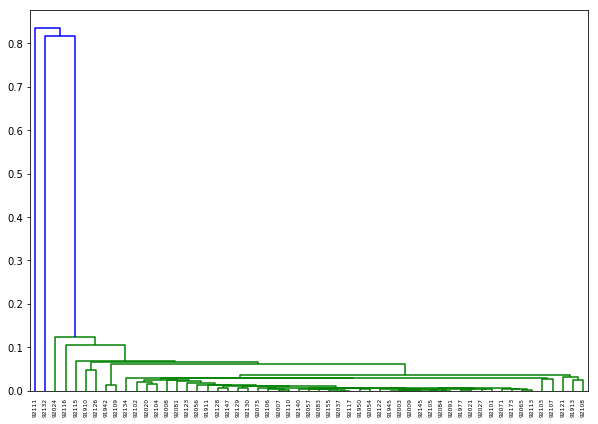

In [288]:
from scipy.cluster.hierarchy import dendrogram, linkage  
from matplotlib import pyplot as plt

linked = linkage(pca.components_.T, 'single')

labelList = list(df_grouped.index)

plt.figure(figsize=(10, 7))  
dendrogram(linked,  
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()  

In [363]:
# set number of clusters
kclusters = 3

# manhattan_grouped_clustering = df_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, n_init = 10 ,max_iter=500, random_state=5).fit(df_grouped)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0], dtype=int32)

In [364]:
df_grouped['label'] = kmeans.labels_

In [365]:
Restaurant_category  = df_grouped.groupby('label').sum().T
Restaurant_category['sum'] = Restaurant_category.sum(axis = 1)

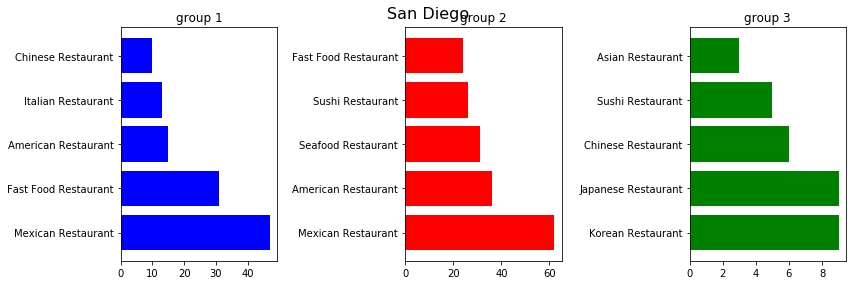

In [373]:
fig,ax = plt.subplots(1,kclusters,figsize = (kclusters*4,4)) 
for i in range(kclusters):
    data = Restaurant_category.sort_values(i,ascending = False).head(5)[i]
    ax[i].set_title('group '+str(i+1))
    ax[i].barh(np.arange(len(data)),width = data,color = dict_color[i])
    ax[i].set_yticks(np.arange(len(data)))
    ax[i].set_yticklabels(list(data.index))
fig.suptitle('San Diego',fontsize = 16)
plt.tight_layout()

In [369]:
# create map of Toronto using latitude and longitude values
map_SD = folium.Map(location=[df_SD_locations.loc[grouped_idx].Lat.mean(), df_SD_locations.loc[grouped_idx].Lng.mean()], zoom_start=10,tiles = 'OpenStreetMap',width=400,height=600)

# add markers to map
for lat, lng, region, col, size in zip(df_SD_locations.loc[grouped_idx]['Lat'], df_SD_locations.loc[grouped_idx]['Lng'], df_SD_locations.loc[grouped_idx]['Region'],[dict_color[c] for c in  kmeans.labels_],df_grouped[Top_20].sum(axis = 1)):
    label = '{}'.format(region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=size/2,
        popup=label,
        color='',
        fill=True,
        fill_color=col,
        fill_opacity=0.5,
        parse_html=True).add_to(map_SD)  
    
map_SD